# Fast Gaussian Process Regression

## Setup

In [1]:
import qmcpy as qp 
import torch 
import numpy as np 
import scipy.stats
import pandas as pd
from matplotlib import pyplot,cm,colors

In [2]:
#pyplot.style.use("seaborn-whitegrid")
LW = 3
CISIZE = .95
ZSTAR = scipy.stats.norm.ppf(CISIZE+(1-CISIZE)/2)
MARKERSIZE = 50
CMAP = cm.inferno
ALPHA = .5
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("./xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
pyplot.style.use("seaborn-v0_8-whitegrid")

In [3]:
torch.set_default_dtype(torch.float64)

## Test functions

In [4]:
def f_grad_f(f,x):
    assert x.ndim==2
    d = x.shape[1]
    xs = [x[:,j] for j in range(d)]
    for j in range(d): xs[j].requires_grad_()
    x = torch.vstack(xs).T
    y = f(x)
    grad = [None]*d 
    for j in range(d):
        grad[j] = torch.autograd.grad(y,xs[j],grad_outputs=torch.ones_like(y),create_graph=True)[0]
    y_grad_y = torch.vstack([y]+grad).T 
    return y_grad_y.detach()
def f_curve_1d(x):
    return np.pi*x[:,0]*torch.sin(4*np.pi*x[:,0])*torch.exp(-.01/(1/2-torch.abs(x[:,0]-1/2)))
def f_G(x): # GFunction from https://www.sfu.ca/~ssurjano/gfunc.html
    assert x.ndim==2
    d = x.shape[1] 
    a = (torch.arange(1,d+1)-2)/2
    y = torch.prod((torch.abs(4*x-2)+a)/(1+a),dim=1)
    return y
def f_peaks(x): # peaks function 
    x = 6*x-3
    x1,x2 = x[:,0],x[:,1]
    t1 = 3*(1-x1)**2*torch.exp(-x1**2-(x2+1)**2)
    t2 = 10*(x1/5-x1**3-x2**5)*torch.exp(-x1**2-x2**2)
    t3 = 1/3*torch.exp(-(x1-1)**2-x2**2)
    return t1-t2-t3
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768): # https://www.sfu.ca/~ssurjano/ackley.html
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
def f_brownian_motion(t, seed=23, numklterms=250): # eq 6.8 https://artowen.su.domains/mc/Ch-processes.pdf
    assert t.size(1)==1
    j = torch.arange(numklterms)
    z_j = torch.from_numpy(np.random.Generator(np.random.PCG64(seed)).uniform(0,1,numklterms))
    bm = np.sqrt(2)/np.pi*(z_j*2/(2*j+1)*torch.sin((2*j+1)/2*np.pi*t)).sum(1)
    return bm
def f_branin_2d(x, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)): # https://www.sfu.ca/~ssurjano/branin.html
    assert x.size(1)==2
    x1,x2 = 15*x[:,0]-5,15*x[:,1]
    y = a*(x2-b*x1**2+c*x1-r)**2+s*(1-t)*torch.cos(x1)+s
    return y
def f_camel_six_hump_2d(x): # https://www.indusmic.com/post/six-hump-camel-function
    assert x.size(1)==2
    x1,x2 = 6*x[:,0]-3,4*x[:,1]-2
    y = (4-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2
    return y 
def styblinski_tang(x): # https://www.sfu.ca/~ssurjano/stybtang.html
    x = 10*x-5
    y = 1/2*torch.sum(x**4-16*x**2+5*x,1)
    return y
def hartmann_6d(x):
    assert x.size(1)==6 
    alpha = torch.tensor([1.0, 1.2, 3.0, 3.2])
    A = torch.tensor([
        [10,   3,   17,   3.5, 1.7, 8],
        [0.05, 10,  17,   0.1, 8,   14],
        [3,    3.5, 1.7,  10,  17,  8],
        [17,   8,   0.05, 10,  0.1,  14]])
    P = 10**(-4)*torch.tensor([
        [1312, 1696, 5569, 124, 8283, 5886],
        [2329, 4135, 8307, 3736, 1004, 9991],
        [2348, 1451, 3522, 2883, 3047, 6650],
        [4047, 8828, 8732, 5743, 1091, 381]])
    y = -1/1.94*(2.58+torch.sum(alpha*torch.exp(-torch.einsum("ij,rij->ri",A,(x[:,None,:]-P)**2)),1))
    return y
def welch(x):
    assert x.size(1)==20
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20 = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4],x[:,5],x[:,6],x[:,7],x[:,8],x[:,9],x[:,10],x[:,11],x[:,12],x[:,13],x[:,14],x[:,15],x[:,16],x[:,17],x[:,18],x[:,19]
    y = 5*x12/(1+x1)+5*(x4-x20)**2+x5+40*x19**3-5*x19+0.05*x2+0.08*x3-0.03*x6+0.03*x7-0.09*x9-0.01*x10-0.07*x11+0.25*x13**2-0.04*x14+0.06*x15-0.01*x17-0.03*x18
    return y

## Pointsets

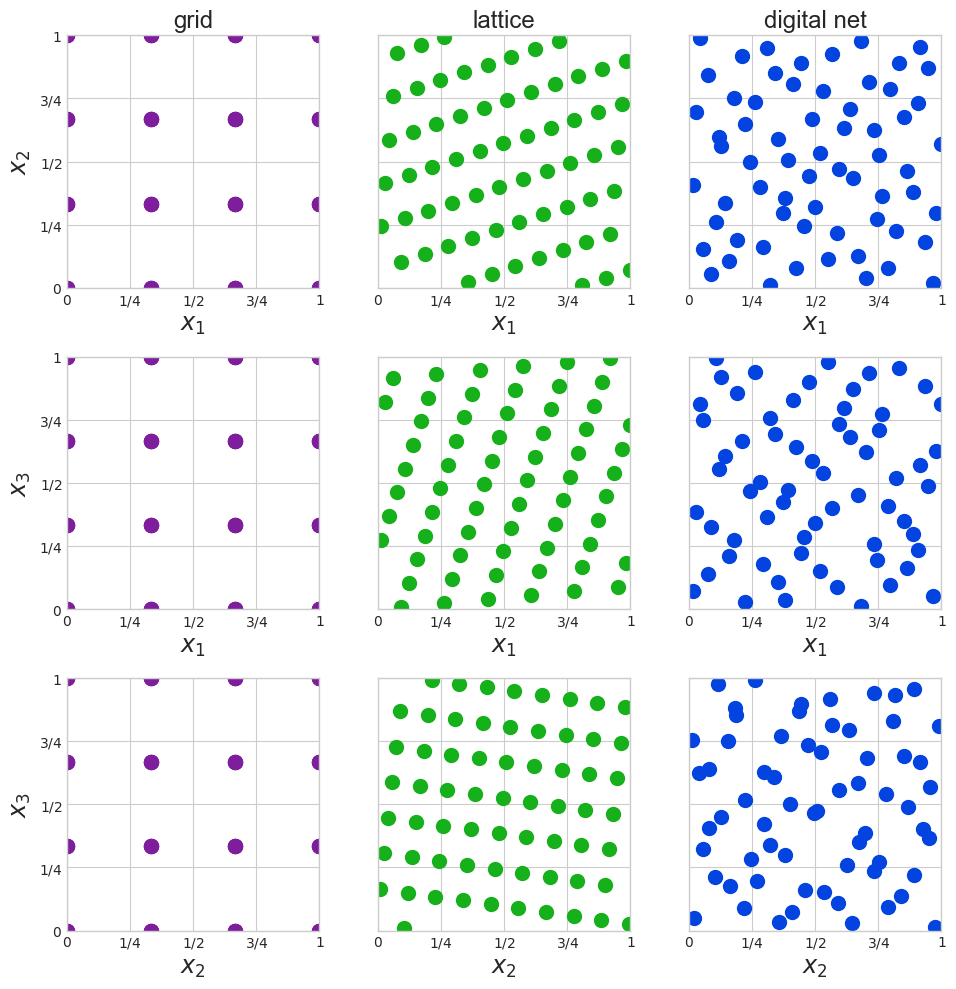

In [5]:
n = 2**6
d = 3
ngrid = np.round(n**(1/d))
assert ngrid**d==n
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)) for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = qp.Lattice(d,order="LINEAR",seed=7)(n)
dnb2 = qp.DigitalNetB2(d,seed=7,graycode=False,t_lms=32)
x_dnb2 = dnb2(n)
fig,ax = pyplot.subplots(nrows=3,ncols=3,figsize=(4*2.5,4*2.5),sharey="row")
S = 100
for j,(name,x) in enumerate(zip(["grid","lattice","digital net"],[grid,x_lattice,x_dnb2])):
    ax[0,j].set_title(name,fontsize="xx-large")
    ax[0,j].scatter(x[:,0],x[:,1],s=S,color=COLORS[j])
    ax[1,j].scatter(x[:,0],x[:,2],s=S,color=COLORS[j])
    ax[2,j].scatter(x[:,1],x[:,2],s=S,color=COLORS[j])
    ax[0,j].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[1,j].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[2,j].set_xlabel(r"$x_2$",fontsize="xx-large")
    for i in range(3):
        ax[i,j].set_xlim([0,1]); ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1/4,1/2,3/4,1])
        ax[i,j].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
        ax[i,j].set_yticks([0,1/4,1/2,3/4,1])
        ax[i,j].set_yticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
        ax[i,j].set_aspect(1)
ax[0,0].set_ylabel(r"$x_2$",fontsize="xx-large")
ax[1,0].set_ylabel(r"$x_3$",fontsize="xx-large")
ax[2,0].set_ylabel(r"$x_3$",fontsize="xx-large")
fig.tight_layout()
fig.savefig("./fgpr_figs/points.pdf",dpi=256,bbox_inches="tight")

## Kernel Matrix Structures

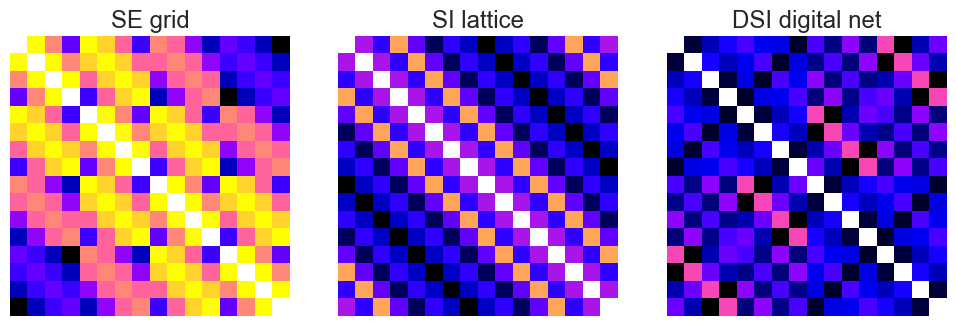

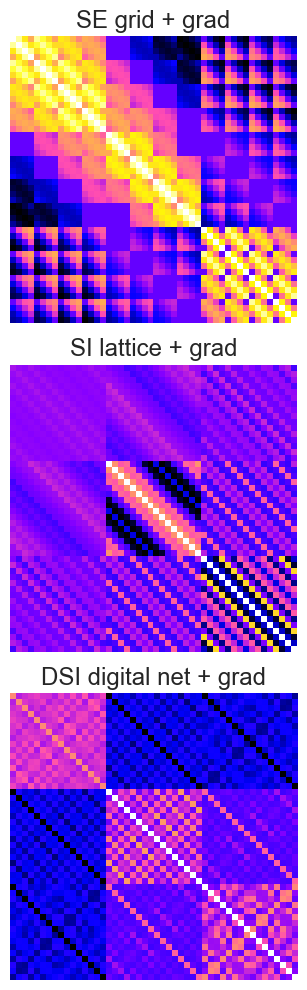

In [6]:
n = 2**4
d = 2
ngrid = np.round(n**(1/d))
assert ngrid**d==n
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)) for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = qp.Lattice(d,order="LINEAR",seed=7)(n)
dnb2 = qp.DigitalNetB2(d,seed=7,graycode=False,t_lms=32)
x_dnb2 = dnb2(n)
i0mesh,i1mesh = torch.meshgrid(torch.arange(n),torch.arange(n),indexing="ij")
lbetas_grad = [np.zeros((1,d),dtype=int)]+[ej for ej in np.eye(d,dtype=int)]
kernel_gauss = qp.KernelGaussian(dimension=d,lengthscales=1e0)
kmat_gauss = kernel_gauss(grid,grid)
kmat_gauss_grad = qp.GramMatrix(kernel_gauss,grid.numpy(),grid.numpy(),lbeta1s=lbetas_grad,lbeta2s=lbetas_grad).full_mat
kernel_si = qp.KernelShiftInvar(dimension=d,lengthscales=2.5e-1,alpha=4)
kamt_si = kernel_si(x_lattice,x_lattice)
kmat_si_grad = qp.GramMatrix(kernel_si,x_lattice,x_lattice,lbeta1s=lbetas_grad,lbeta2s=lbetas_grad).full_mat
kernel_dsi = qp.KernelDigShiftInvar(dimension=d,t=dnb2.t_lms,lengthscales=2.5e-1,alpha=4)
xb_dnb2 = (2**dnb2.t_lms*x_dnb2).astype(np.uint64)
kmat_dsi = kernel_dsi(xb_dnb2,xb_dnb2)
kmat_dsi_grad = qp.GramMatrix(kernel_dsi,xb_dnb2,xb_dnb2,lbeta1s=lbetas_grad,lbeta2s=lbetas_grad).full_mat
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(4*2.5,3.25))
fig_grad,ax_grad = pyplot.subplots(nrows=3,ncols=1,figsize=(3.25,4*2.5))
CMAP = "gnuplot2"
for i,(name,kmat) in enumerate(zip(["SE grid","SI lattice", "DSI digital net"],[kmat_gauss,kamt_si,kmat_dsi])):
    #print(name) 
    #print(kmat[:4,:4])
    #print()
    ax[i].imshow(kmat,cmap=CMAP)
    ax[i].set_title(name,fontsize="xx-large")
for i,(name,kmat) in enumerate(zip(["SE grid","SI lattice", "DSI digital net"],[kmat_gauss_grad,kmat_si_grad,kmat_dsi_grad])):
    #print(name) 
    #print(kmat[:4,:4])
    #print()
    ax_grad[i].imshow(kmat,cmap=CMAP)
    ax_grad[i].set_title(name+" + grad",fontsize="xx-large")
for i in range(3):
    for axi in [ax[i],ax_grad[i]]:
        axi.axis("off")
        axi.set_aspect(1)
for figgy in [fig,fig_grad]:
    figgy.tight_layout()
fig.savefig("./fgpr_figs/gram_matrix_structures.pdf",dpi=256,bbox_inches="tight")
fig_grad.savefig("./fgpr_figs/gram_matrix_structures_grad.pdf",dpi=256,bbox_inches="tight")

## Prior Draws

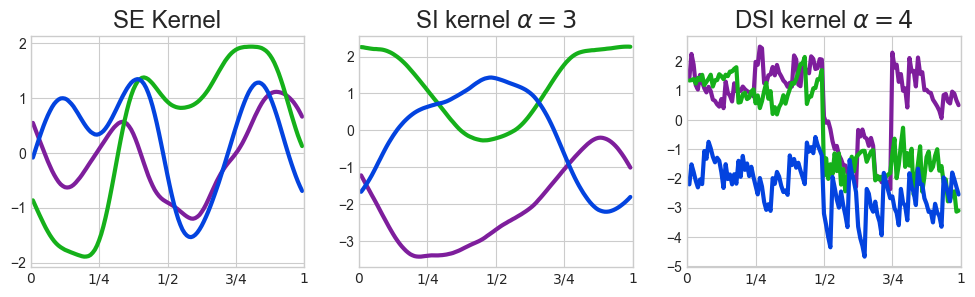

In [7]:
ndraws = 3
n = 127
t = 32
xticks = torch.linspace(0,1,n+2)[1:-1]
xbticks = torch.floor(xticks*2**t).to(torch.int64)
kmats = [
    ["SE Kernel", qp.KernelGaussian(dimension=1,torchify=True,lengthscales=1e-2)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=2$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=2)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    [r"SI kernel $\alpha=3$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=3)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=4$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=4)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=5$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=5)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"DSI kernel $\alpha = 2$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=2)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n)],
    #[r"DSI kernel $\alpha = 3$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=3)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n)],
    [r"DSI kernel $\alpha = 4$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=4)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n)],
]
nrows = len(kmats)
#fig,ax = pyplot.subplots(nrows=nrows,ncols=1,figsize=(6,4*nrows))
fig,ax = pyplot.subplots(nrows=1,ncols=nrows,figsize=(4*nrows,3),sharex=True,sharey=False)
for i,(name,kmat) in enumerate(kmats):
    L = torch.linalg.cholesky(kmat)
    r = torch.randn(ndraws,n)
    draws = torch.einsum("ik,rk->ri",L,r)
    for j in range(ndraws):
        ax[i].plot(xticks,draws[j],color=COLORS[j],linewidth=LW)
        ax[i].set_title(name,fontsize="xx-large")
        ax[i].set_xlim([0,1])
        ax[i].set_xticks([0,1/4,1/2,3/4,1])
        ax[i].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
fig.savefig("./fgpr_figs/gp_draws.pdf",dpi=256,bbox_inches="tight")

## Test Functions

In [ ]:
funcs = [
    ("Ackley",1,f_ackley,False,False),
    ("Branin",2,f_branin_2d,False,True),
    ("Camel",2,f_camel_six_hump_2d,False,False),
    ("Styblinski",2,styblinski_tang,False,False),
    ("Hartmann",6,hartmann_6d,False,True),
    #("Welch",20,welch),
    ]
n = 2**10
gps = [
    ["SE lattice", lambda n,d,lbetas: qp.GPR(qp.Lattice(d,seed=7),n=n,lbetas=lbetas)],
    ["SI lattice", lambda n,d,lbetas: qp.FGPRLattice(qp.Lattice(d,seed=7),n=n,lbetas=lbetas,alpha=3)],
    ["DSI digital net", lambda n,d,lbetas: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d,seed=7),n=n,lbetas=lbetas,alpha=4)],
]
verbose_indent = 12
opt_steps = 250
verbose = max(1,opt_steps//5)
l2rerrors_no_grad = torch.nan*torch.ones((len(funcs),len(gps)))
l2rerrors_grad = torch.nan*torch.ones((len(funcs),len(gps)))
times_no_grad = torch.nan*torch.ones((len(funcs),len(gps)))
times_grad = torch.nan*torch.ones((len(funcs),len(gps)))
datas = {}
datas_grad = {}
for i,(fname,d,f,bake,bake_grad) in enumerate(funcs):
    print(fname)
    xquery = torch.from_numpy(qp.Halton(d,seed=17).gen_samples(2**12))
    yquery = f(xquery)
    for j,(name,gp_constructor) in enumerate(gps):
        print("    %s"%name)
        print("        nograd ")
        lbetas = [torch.zeros((1,d),dtype=int)]
        gp = gp_constructor(n,d,lbetas)
        f_tf = (lambda x: f(1-2*torch.abs(x-1/2))) if isinstance(gp,qp.FGPRLattice) and bake else f # possible Baker transform
        yf = f(gp.x)[:,None]
        data = gp.fit(yf,
            #xquery,yquery,
            verbose_indent=verbose_indent,opt_steps=opt_steps,verbose=verbose)
        times_no_grad[i,j] = torch.mean(data["times"][2:-1]-data["times"][1:-2])
        yhat = (gp.post_mean(xquery/2)+gp.post_mean(1-xquery/2))/2  if isinstance(gp,qp.FGPRLattice) and bake else gp.post_mean(xquery) # inverse Baker transform
        l2rerrors_no_grad[i,j] = torch.linalg.norm(yhat-yquery)/torch.linalg.norm(yquery)
        print("            L2 relative error = %.2e\ttime = %.2e"%(l2rerrors_no_grad[i,j],times_no_grad[i,j]))
        datas[fname+"_"+name] = data
        print("        grad ")
        lbetas = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
        gp = gp_constructor(n,d,lbetas)
        f_tf = (lambda x: f(1-2*torch.abs(x-1/2))) if isinstance(gp,qp.FGPRLattice) and bake_grad else f # possible Baker transform
        yf = f_grad_f(f_tf,gp.x)
        data = gp.fit(yf,
            #xquery,yquery,
            verbose_indent=verbose_indent,opt_steps=opt_steps,verbose=verbose)
        times_grad[i,j] = torch.mean(data["times"][2:-1]-data["times"][1:-2])
        yhat = (gp.post_mean(xquery/2)+gp.post_mean(1-xquery/2))/2 if isinstance(gp,qp.FGPRLattice) and bake_grad else gp.post_mean(xquery) # inverse Baker transform
        l2rerrors_grad[i,j] = torch.linalg.norm(yhat-yquery)/torch.linalg.norm(yquery)
        datas_grad[fname+"_"+name] = data
        print("            L2 relative error = %.2e\ttime = %.2e"%(l2rerrors_grad[i,j],times_grad[i,j]))
    print()

Ackley
    SE lattice
        nograd 
                iter of 250 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                          0 | 7.52e+09        nan             | 1.00e-01        | [1.00e+00]	[1.00e+00]	[1.01e-06]
                         50 | 1.04e+09        nan             | 1.00e-01        | [2.68e-02]	[1.89e+01]	[1.01e-06]
                        100 | 7.71e+08        nan             | 1.00e-01        | [9.29e-03]	[3.02e+01]	[1.01e-06]
                        150 | 7.32e+08        nan             | 1.00e-01        | [5.99e-03]	[3.54e+01]	[1.01e-06]
                        200 | 7.16e+08        nan             | 1.00e-01        | [4.47e-03]	[3.92e+01]	[1.01e-06]
                        250 | 7.08e+08        nan             | 1.00e-01        | [3.58e-03]	[4.24e+01]	[1.01e-06]
            L2 relative error = 4.40e-

In [9]:
with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
    print("l2rerrors_no_grad\n")
    print(l2rerrors_no_grad.numpy())
    print("\n\nl2rerrors_grad")
    print(l2rerrors_grad.numpy())
    print("\n\ntimes_no_grad")
    print(times_no_grad.numpy())
    print("\n\ntimes_grad")
    print(times_grad.numpy())

l2rerrors_no_grad

[[4.3e-02 4.8e-04 3.8e-02]
 [1.3e-04 2.2e-01 3.2e-02]
 [1.1e-03 3.8e-02 7.2e-02]
 [7.2e-04 6.6e-02 7.7e-02]
 [5.1e-02 7.1e-02 8.7e-02]]


l2rerrors_grad
[[4.3e-02 2.2e-04 3.8e-02]
 [2.4e-05 5.6e-03 3.4e-02]
 [3.3e-03 2.3e-02 8.0e-02]
 [1.2e-03 5.4e-02 7.7e-02]
 [2.4e-02 5.3e-02 1.1e-01]]


times_no_grad
[[1.3e-02 7.9e-04 2.1e-03]
 [1.8e-02 9.0e-04 2.3e-03]
 [1.8e-02 8.5e-04 2.3e-03]
 [1.8e-02 8.6e-04 2.3e-03]
 [3.3e-02 1.1e-03 3.0e-03]]


times_grad
[[6.5e-02 2.2e-03 4.7e-03]
 [1.7e-01 4.8e-03 1.0e-02]
 [1.7e-01 4.6e-03 1.0e-02]
 [1.7e-01 4.7e-03 1.1e-02]
 [1.7e+00 3.1e-02 8.0e-02]]


In [11]:
fnames = [item[0] for item in funcs]
_s = r"""  \begin{tabular}{r|%s|%s}
"""%("".join("cc" for name,gp in gps),"".join("cc" for name,gp in gps))
_s += "    " + "& " + r"\multicolumn{%d}{c|}{$L_2$ relative error} & \multicolumn{%d}{c}{time per optimization step} \\"%(2*len(gps),2*len(gps))+ "\n"
_s += "   "+" & "+" & ".join(r"\multicolumn{2}{c}{%s}"%name for name,gp in gps) +" & " + " & ".join(r"\multicolumn{2}{c}{%s}"%name for name,gp in gps) + r" \\" + "\n"
_s += "    "+"benchmark & " + " & ".join(r"$f$ & $(f, \nabla f)$" for name,gp in gps) + " & " + " & ".join(r"$f$ & $(f, \nabla f)$" for name,gp in gps) + r" \\" + "\n"
_s += "    "+r"\hline" + "\n"
for i in range(len(l2rerrors_no_grad)):
    _t = ("        "+ "%s & "%fnames[i] 
    + " & ".join(r"%.1e & %.1e"%(l2rerrors_no_grad[i,j],l2rerrors_grad[i,j]) for j in range(l2rerrors_no_grad.size(1)))
    + " & "  
    + " & ".join(r"%.1e & %.1e"%(times_no_grad[i,j],times_grad[i,j]) for j in range(times_no_grad.size(1))) 
    + r" \\" + "\n")
    _t = _t.replace("e-0","e-").replace("e+0","e").replace("Styblinski","StyTang")
    _s += _t
_s += r"  \end{tabular}"
print(_s)

  \begin{tabular}{r|cccccc|cccccc}
    & \multicolumn{6}{c|}{$L_2$ relative error} & \multicolumn{6}{c}{time per optimization step} \\
    & \multicolumn{2}{c}{SE lattice} & \multicolumn{2}{c}{SI lattice} & \multicolumn{2}{c}{DSI digital net} & \multicolumn{2}{c}{SE lattice} & \multicolumn{2}{c}{SI lattice} & \multicolumn{2}{c}{DSI digital net} \\
    benchmark & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ \\
    \hline
        Ackley & 4.3e-2 & 4.3e-2 & 4.8e-4 & 2.2e-4 & 3.8e-2 & 3.8e-2 & 1.3e-2 & 6.5e-2 & 7.9e-4 & 2.2e-3 & 2.1e-3 & 4.7e-3 \\
        Branin & 1.3e-4 & 2.4e-5 & 2.2e-1 & 5.6e-3 & 3.2e-2 & 3.4e-2 & 1.8e-2 & 1.7e-1 & 9.0e-4 & 4.8e-3 & 2.3e-3 & 1.0e-2 \\
        Camel & 1.1e-3 & 3.3e-3 & 3.8e-2 & 2.3e-2 & 7.2e-2 & 8.0e-2 & 1.8e-2 & 1.7e-1 & 8.5e-4 & 4.6e-3 & 2.3e-3 & 1.0e-2 \\
        StyTang & 7.2e-4 & 1.2e-3 & 6.6e-2 & 5.4e-2 & 7.7e-2 & 7.7e-2 & 1.8e-2 & 1.7e-1 & 8.6e-4 & 4.

## 1d example

<function f_brownian_motion at 0x361baa550>
	SE grid
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 1.39e+06        1.87e-01        | 1.00e-01        | [1.00e+00]	[1.00e+00]	[1.00e-08]
                 50 | 1.72e+01        2.09e-01        | 1.00e-01        | [2.89e-02]	[3.18e+01]	[1.00e-08]
                100 | 1.79e+01        2.06e-01        | 1.00e-01        | [2.80e-02]	[3.27e+01]	[1.00e-08]
	SI lattice
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | -1.06e+01       9.07e-02        | 1.00e-01        | [1.00e+00]	[1.00e+00]	[1.00e-08]
                 50 | -1.66e+01       9.07e-02        | 1.00e-01       

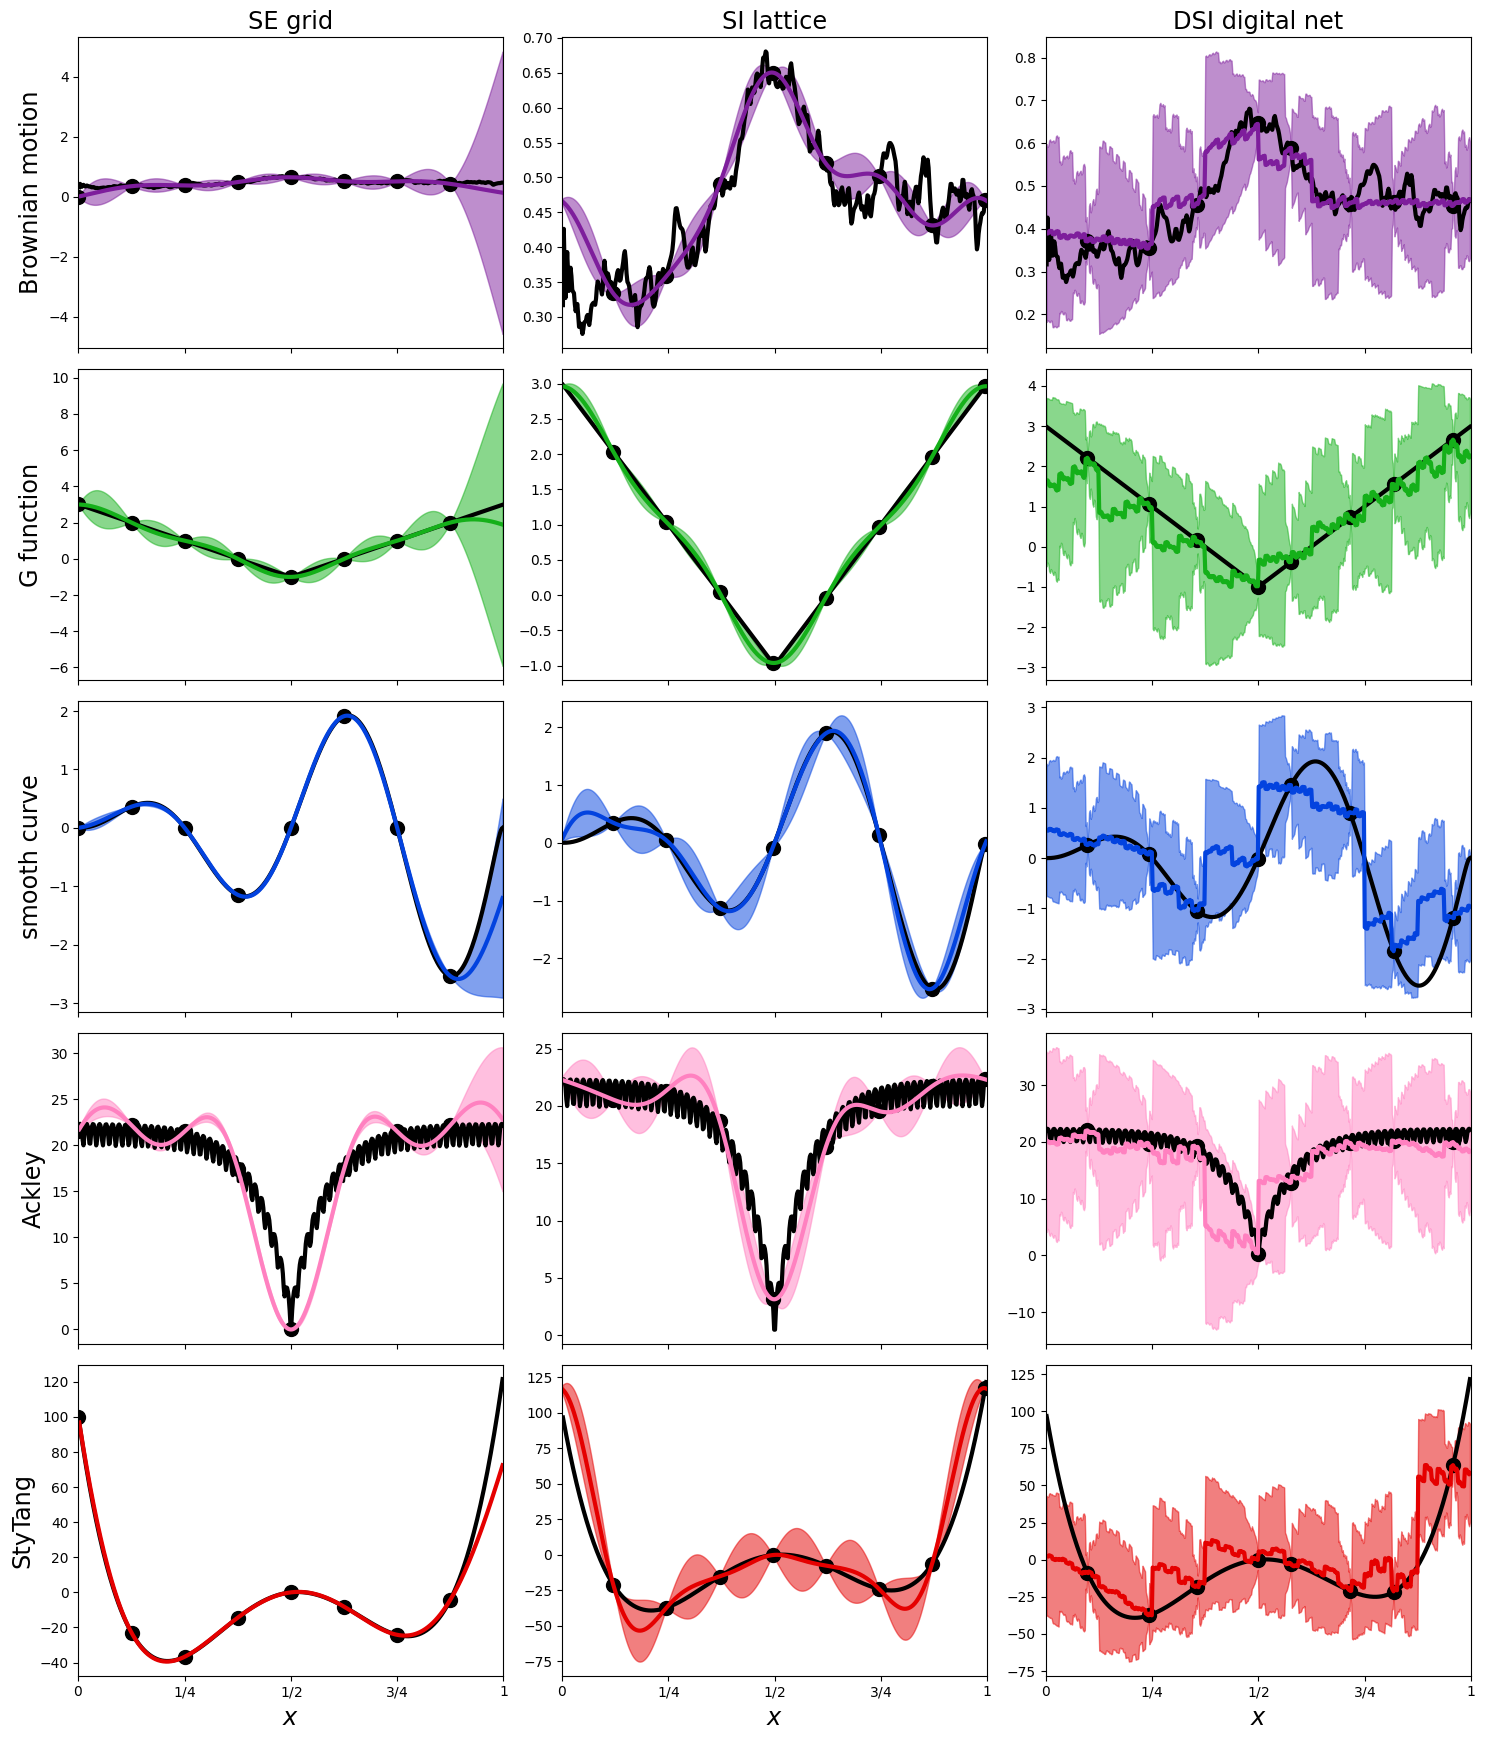

In [ ]:
d = 1
n = 2**3
nticks = 500
xticks = torch.linspace(0,1,nticks+2)[1:-1]
grid = torch.linspace(0,1,n+1)[:-1,None]
lattice = qp.Lattice(d,seed=17) 
dnb2 = qp.DigitalNetB2(d,seed=7)
lbetas_no_grad = [torch.zeros((1,d),dtype=int)]
lbetas_grad = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
gps = [
    ["SE grid", qp.GPR(grid,lbetas=lbetas_no_grad),False],
    #[r"Fast GPR, SI kernel, lattice $\alpha = 2$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,alpha=2),False],
    [r"SI lattice", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,alpha=3),False],
    #[r"Fast GPR, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,alpha=4),False],
    #[r"Fast GPR, DSI kernel, digital net $\alpha = 2$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,alpha=2),False],
    #[r"Fast GPR, DSI kernel, digital net $\alpha = 3$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,alpha=3),False],
    [r"DSI digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,alpha=4),False],
    #["GP + derivative, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_grad), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 3$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,alpha=3), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,alpha=4), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 5$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,alpha=5), True],
    #["Fast GP + derivative, DSI kernel, digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,alpha=4), True],
]
funcs = [f_brownian_motion,f_G,f_curve_1d,f_ackley,styblinski_tang]
fnames = ["Brownian motion","G function","smooth curve","Ackley","StyTang"]
ncols = len(gps)
nrows = len(funcs)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(5*ncols,3.5*nrows),sharex=True,sharey=False)
ax = np.atleast_1d(ax).reshape((nrows,ncols))
for j,(f,fname) in enumerate(zip(funcs,fnames)):
    yticks = f(xticks[:,None])
    print(f)
    for i,(name,gp,grad) in enumerate(gps):
        print("\t"+name)
        if not grad:
            yf = f(gp.x)[:,None]
        else:
            yf = f_grad_f(f,gp.x)
        ax[j,i].plot(xticks.cpu(),yticks.cpu(),color="k",linewidth=LW)
        data = gp.fit(yf,xticks[:,None],yticks,opt_steps=100,verbose=50,opt_noises=False,lb_noises=1e-12)
        pmean = gp.post_mean(xticks[:,None])
        ax[j,i].plot(xticks.cpu(),pmean.cpu(),color=COLORS[j],linewidth=LW)
        pvar = gp.post_var(xticks[:,None])
        ci_low = pmean-ZSTAR*torch.sqrt(pvar)
        ci_high = pmean+ZSTAR*torch.sqrt(pvar)
        ax[j,i].fill_between(xticks.cpu(),ci_high.cpu(),ci_low.cpu(),color=COLORS[j],alpha=ALPHA)
        ax[j,i].scatter(gp.x[:,0].cpu(),yf[:,0].cpu(),color="k",s=100)
        ax[j,i].set_xlim([0,1])
for i,(name,gp,grad) in enumerate(gps):
    ax[0,i].set_title(name,fontsize="xx-large")
    ax[-1,i].set_xlabel(r"$x$",fontsize="xx-large")
    ax[-1,i].set_xlim([0,1])
    ax[-1,i].set_xticks([0,1/4,1/2,3/4,1])
    ax[-1,i].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
for j,(f,fname) in enumerate(zip(funcs,fnames)):
    ax[j,0].set_ylabel(fname,fontsize="xx-large")
fig.tight_layout()
fig.savefig("./fgpr_figs/gp1d.%s.pdf"%name,dpi=256,bbox_inches="tight")

## 2d example

In [ ]:
d = 2
n = 2**10
f = f_ackley
nticks = 129
x1ticks = x2ticks = torch.linspace(0,1,nticks+2)[1:-1]
x1mesh,x2mesh = torch.meshgrid(x1ticks,x2ticks,indexing="ij")
xticks = torch.vstack([x1mesh.flatten(),x2mesh.flatten()]).T 
yticks = f(xticks)
ymesh = yticks.reshape(x1mesh.shape)

In [ ]:
grid1ticks = grid2ticks = torch.linspace(0,1,int(np.sqrt(n)))
grid1mesh,grid2mesh = torch.meshgrid(grid1ticks,grid2ticks,indexing="ij")
grid = torch.vstack([grid1mesh.flatten(),grid2mesh.flatten()]).T
assert len(grid)==n
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)
dnb2_alpha2 = qp.DigitalNetB2(d,seed=7,alpha=2)
dnb2_alpha3 = qp.DigitalNetB2(d,seed=7,alpha=3)
dnb2_alpha4 = qp.DigitalNetB2(d,seed=7,alpha=4)

In [ ]:
lbetas_grad = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
gps_grad = [
    ["SE grid", qp.GPR(grid,lbetas=lbetas_grad)],
    ["SI lattice", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,alpha=3)],
    ["DSI digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=2", qp.FGPRDigitalNetB2(dnb2_alpha2,n,lbetas=lbetas_grad,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=3", qp.FGPRDigitalNetB2(dnb2_alpha3,n,lbetas=lbetas_grad,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=4", qp.FGPRDigitalNetB2(dnb2_alpha4,n,lbetas=lbetas_grad,alpha=4)],
]
for name,gp in gps_grad:
    print(name) 
    yf = f_grad_f(f,gp.x)
    data = gp.fit(yf,
        #xticks,yticks,
        opt_steps=1000,verbose=50,opt_noises=True,lb_noises=1e-16)
    yhat = gp.post_mean(xticks)
    l2rerror = torch.linalg.norm(yhat-yticks)/torch.linalg.norm(yticks)
    print("    L2RError: %.2e\t time = %.2e"%(l2rerror,data["times"][-1]))
    gp.y = yf

SE grid
       iter of 1000 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 4.63e+15        nan             | 1.00e-01        | [1.00e+00 1.00e+00]	[1.00e+00]	[1.00e-08 1.00e-08 1.00e-08]
                 50 | 3.28e+11        nan             | 1.00e-01        | [1.92e-02 1.92e-02]	[3.88e+01]	[3.64e-06 2.49e-07 2.49e-07]
                100 | 2.79e+11        nan             | 1.00e-01        | [1.80e-02 1.80e-02]	[4.07e+01]	[6.51e-06 2.57e-07 2.57e-07]
                150 | 2.65e+11        nan             | 1.00e-01        | [1.76e-02 1.76e-02]	[4.11e+01]	[9.44e-06 2.59e-07 2.59e-07]
                200 | 2.48e+11        nan             | 1.00e-01        | [1.72e-02 1.72e-02]	[4.15e+01]	[1.28e-05 2.60e-07 2.60e-07]
                250 | 2.28e+11        nan             | 1.00e-01        | [1.66e-02 1.66e-02]	[4.20e+01]

/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_66147/643330572.py:55
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_66147/643330572.py:56
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_66147/643330572.py:55
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_66147/643330572.py:56
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_66147/643330572.py:55
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_66147/643330572.py:56


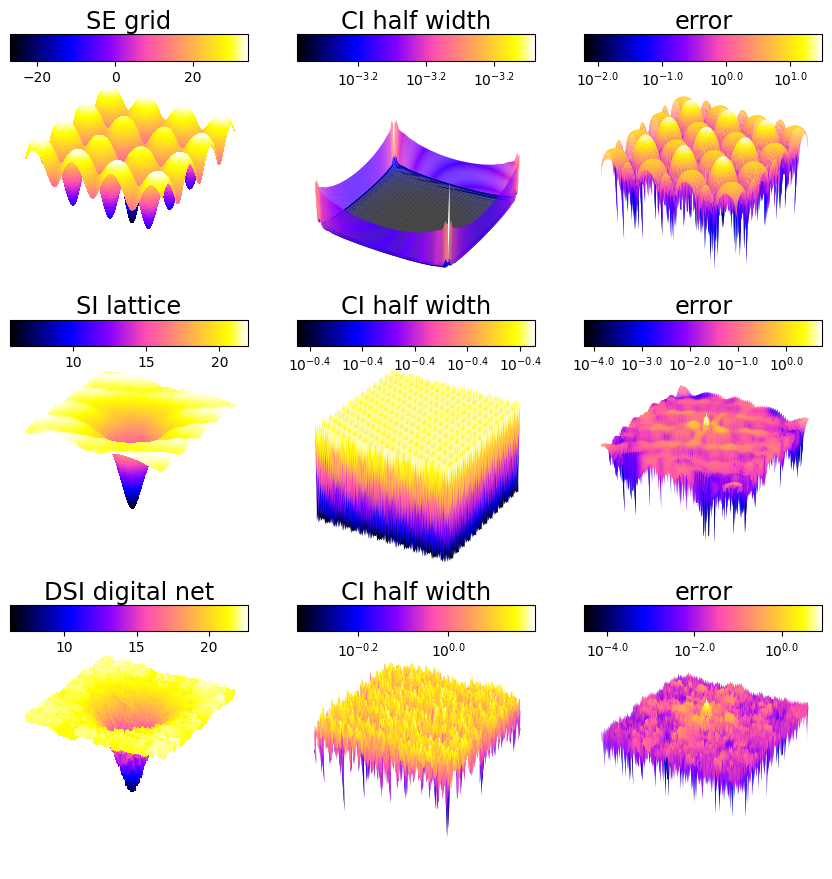

In [ ]:
CMAP = cm.gnuplot2
nrows = len(gps_grad)
ncols = 3
fig = pyplot.figure(figsize=(3.5*ncols,3.5*nrows))
ax = np.array([[fig.add_subplot(nrows,ncols,ncols*i+j+1,projection="3d") for j in range(ncols)] for i in range(nrows)],dtype=object)
pmeanmeshes = torch.vstack([gp.post_mean(xticks).reshape(x1mesh.shape)[None,:,:].cpu() for _,gp in gps_grad])
cihwmeshes = np.log10(ZSTAR*torch.sqrt(torch.vstack([gp.post_var(xticks).reshape(x1mesh.shape)[None,:,:].cpu() for _,gp in gps_grad])))
errormeshes = torch.log10(torch.abs(pmeanmeshes-ymesh.cpu()))
for i,(name,gp) in enumerate(gps_grad):
    pmean_max,pmean_min = pmeanmeshes[i].max(),pmeanmeshes[i].min()
    error_max,error_min = errormeshes[i].max(),errormeshes[i].min()
    cihw_max,cihw_min = cihwmeshes[i].max(),cihwmeshes[i].min()
    norm_pmean = colors.Normalize(vmin=pmean_min,vmax=pmean_max)
    norm_err = colors.Normalize(vmin=error_min,vmax=error_max)
    norm_cihw = colors.Normalize(vmin=cihw_min,vmax=cihw_max)
    surf_func = ax[i,0].plot_surface(x1mesh.cpu(),x2mesh.cpu(),pmeanmeshes[i],
        cmap=CMAP,
        #vmin=pmean_min,vmax=pmean_max,
        #facecolors=CMAP(norm_pmean(pmeanmeshes[i])),
        antialiased=False,rstride=1,cstride=1,edgecolor='none')
    surf_cihw = ax[i,1].plot_surface(x1mesh.cpu(),x2mesh.cpu(),cihwmeshes[i],
        cmap=CMAP,
        #vmin=cihw_min,vmax=cihw_max,
        #facecolors=CMAP(norm_cihw(cihwmeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    surf_err = ax[i,2].plot_surface(x1mesh.cpu(),x2mesh.cpu(),errormeshes[i],
        cmap=CMAP,
        #vmin=error_min,vmax=error_max,
        #facecolors=CMAP(norm_err(errormeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    cax_pmean = fig.add_axes([
        ax[i,0].get_position().x0,
        ax[i,0].get_position().y1,
        ax[i,0].get_position().x1-ax[i,0].get_position().x0,
        0.025,
    ])
    cax_cihw = fig.add_axes([
        ax[i,1].get_position().x0,
        ax[i,1].get_position().y1,
        ax[i,1].get_position().x1-ax[i,1].get_position().x0,
        0.025,
    ])
    cax_err = fig.add_axes([
        ax[i,2].get_position().x0,
        ax[i,2].get_position().y1,
        ax[i,2].get_position().x1-ax[i,2].get_position().x0,
        0.025,
    ])
    cbar_pmean = fig.colorbar(cm.ScalarMappable(norm=norm_pmean,cmap=CMAP),cax_pmean,orientation="horizontal")
    cbar_pmean.ax.set_xlabel(name,fontsize='xx-large')
    cbar_cihw = fig.colorbar(cm.ScalarMappable(norm=norm_cihw,cmap=CMAP),cax_cihw,orientation="horizontal")
    cbar_cihw.ax.set_xlabel("CI half width",fontsize='xx-large')
    cbar_err = fig.colorbar(cm.ScalarMappable(norm=norm_err,cmap=CMAP),cax_err,orientation="horizontal")
    cbar_err.ax.set_xlabel("error",fontsize='xx-large')
    cbar_err.ax.set_xticklabels([r"$10^{%.1f}$"%tick for tick in cbar_err.ax.get_xticks()])
    cbar_cihw.ax.set_xticklabels([r"$10^{%.1f}$"%tick for tick in cbar_cihw.ax.get_xticks()])
    cbar_err.ax.xaxis.set_label_position('top')
    cbar_cihw.ax.xaxis.set_label_position('top')
    cbar_pmean.ax.xaxis.set_label_position('top')
    #ax[i,0].set_title(name)
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].axis("off")
        ax[i,j].set_xlim([0,1]); ax[i,j].set_xticks([0,1])
        ax[i,j].set_ylim([0,1]); ax[i,j].set_yticks([0,1])
        ax[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax[i,j].yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax[i,j].zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
         #ax[i,j].set_xlabel(r"$x_1$",fontsize="xx-large")
        #ax[i,j].set_ylabel(r"$x_2$",fontsize="xx-large")
    ax[i,0].set_zlabel(r"$f(\mathbf{x})$",fontsize="xx-large")
    ax[i,1].set_zlabel(r"$|f(\mathbf{x})-f_{\mathrm{true}}(\mathbf{x})|$",fontsize="xx-large")
    #ax[i,0].set_zlim([pmeanmeshes.min(),pmeanmeshes.max()]); ax[i,j].set_yticks([0,1])
    #ax[i,1].zaxis._set_scale('log')
    #ax[i,1].set_zscale("log",base=10)
#fig.tight_layout()
fig.savefig("./fgpr_figs/fgp_2d.pdf",bbox_inches="tight",dpi=256)

## Speed Comparison

In [ ]:
dvec = 2**torch.arange(0,6,dtype=int)
nvec = 2**torch.arange(0,10,dtype=int)
gps = [
    ["SE lattice", lambda d,n,lbetas: qp.GPR(qp.Lattice(d),n,lbetas=lbetas)],
    ["SI lattice", lambda d,n,lbetas: qp.FGPRLattice(qp.Lattice(d),n,lbetas=lbetas)],
    ["DSI digital net", lambda d,n,lbetas: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d),n,lbetas=lbetas,alpha=4)],
]
print("dvec = %s"%str(dvec.numpy()))
print("nvec = %s"%str(nvec.numpy()))
print()
times = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
times_grad = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors_grad = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
for j,d in enumerate(dvec):
    x_test = torch.from_numpy(qp.Halton(d,seed=7)(2**10))
    y_test = f_ackley(x_test)
    print("d = %d"%d)
    for i,n in enumerate(nvec):
        print("    n = %d"%n)
        for k,(name,gp_constructor) in enumerate(gps):
            # no grad
            lbetas = [torch.zeros(d,dtype=int)]
            gp = gp_constructor(d,int(n),lbetas)
            y = f_ackley(gp.x)[:,None]
            data = gp.fit(y,opt_steps=250,verbose=0,opt_noises=True,lb_noises=1e-12,verbose_indent=8)
            yhat = gp.post_mean(x_test)
            l2rerrors[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            times[k,j,i] = torch.mean(data["times"][10:-10]-data["times"][9:-11])
            print("        %35s: \tl2 relative error = %-15.2e time = %-15.2e"%(name,l2rerrors[k,j,i],times[k,j,i]))
            # grad
            # lbetas_grad = [torch.zeros(d,dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
            # gp = gp_constructor(d,int(n),lbetas_grad)
            # y = f_grad_f(f_ackley,gp.x)
            # data = gp.fit(y,opt_steps=50,verbose=0,opt_noises=True,lb_noises=1e-6,verbose_indent=8)
            # yhat = gp.post_mean(x_test)
            # l2rerrors_grad[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            # times_grad[k,j,i] = torch.mean(data["times"][10:-10]-data["times"][9:-11])
            # print("        %35s: \tl2 relative error = %-15.2e time = %-15.2e"%(name+" + grad",l2rerrors_grad[k,j,i],times_grad[k,j,i]))

dvec = [ 1  2  4  8 16 32]
nvec = [  1   2   4   8  16  32  64 128 256 512]

d = 1
    n = 1
                                 SE lattice: 	l2 relative error = 2.95e-01        time = 4.45e-04       
                                 SI lattice: 	l2 relative error = 1.20e+00        time = 7.40e-04       
                            DSI digital net: 	l2 relative error = 1.05e+00        time = 1.04e-03       
    n = 2
                                 SE lattice: 	l2 relative error = 6.23e-01        time = 5.27e-04       
                                 SI lattice: 	l2 relative error = 2.71e-01        time = 7.77e-04       
                            DSI digital net: 	l2 relative error = 2.66e-01        time = 1.30e-03       
    n = 4
                                 SE lattice: 	l2 relative error = 1.56e-01        time = 5.67e-04       
                                 SI lattice: 	l2 relative error = 1.92e-01        time = 7.62e-04       
                            DSI digital net: 	l

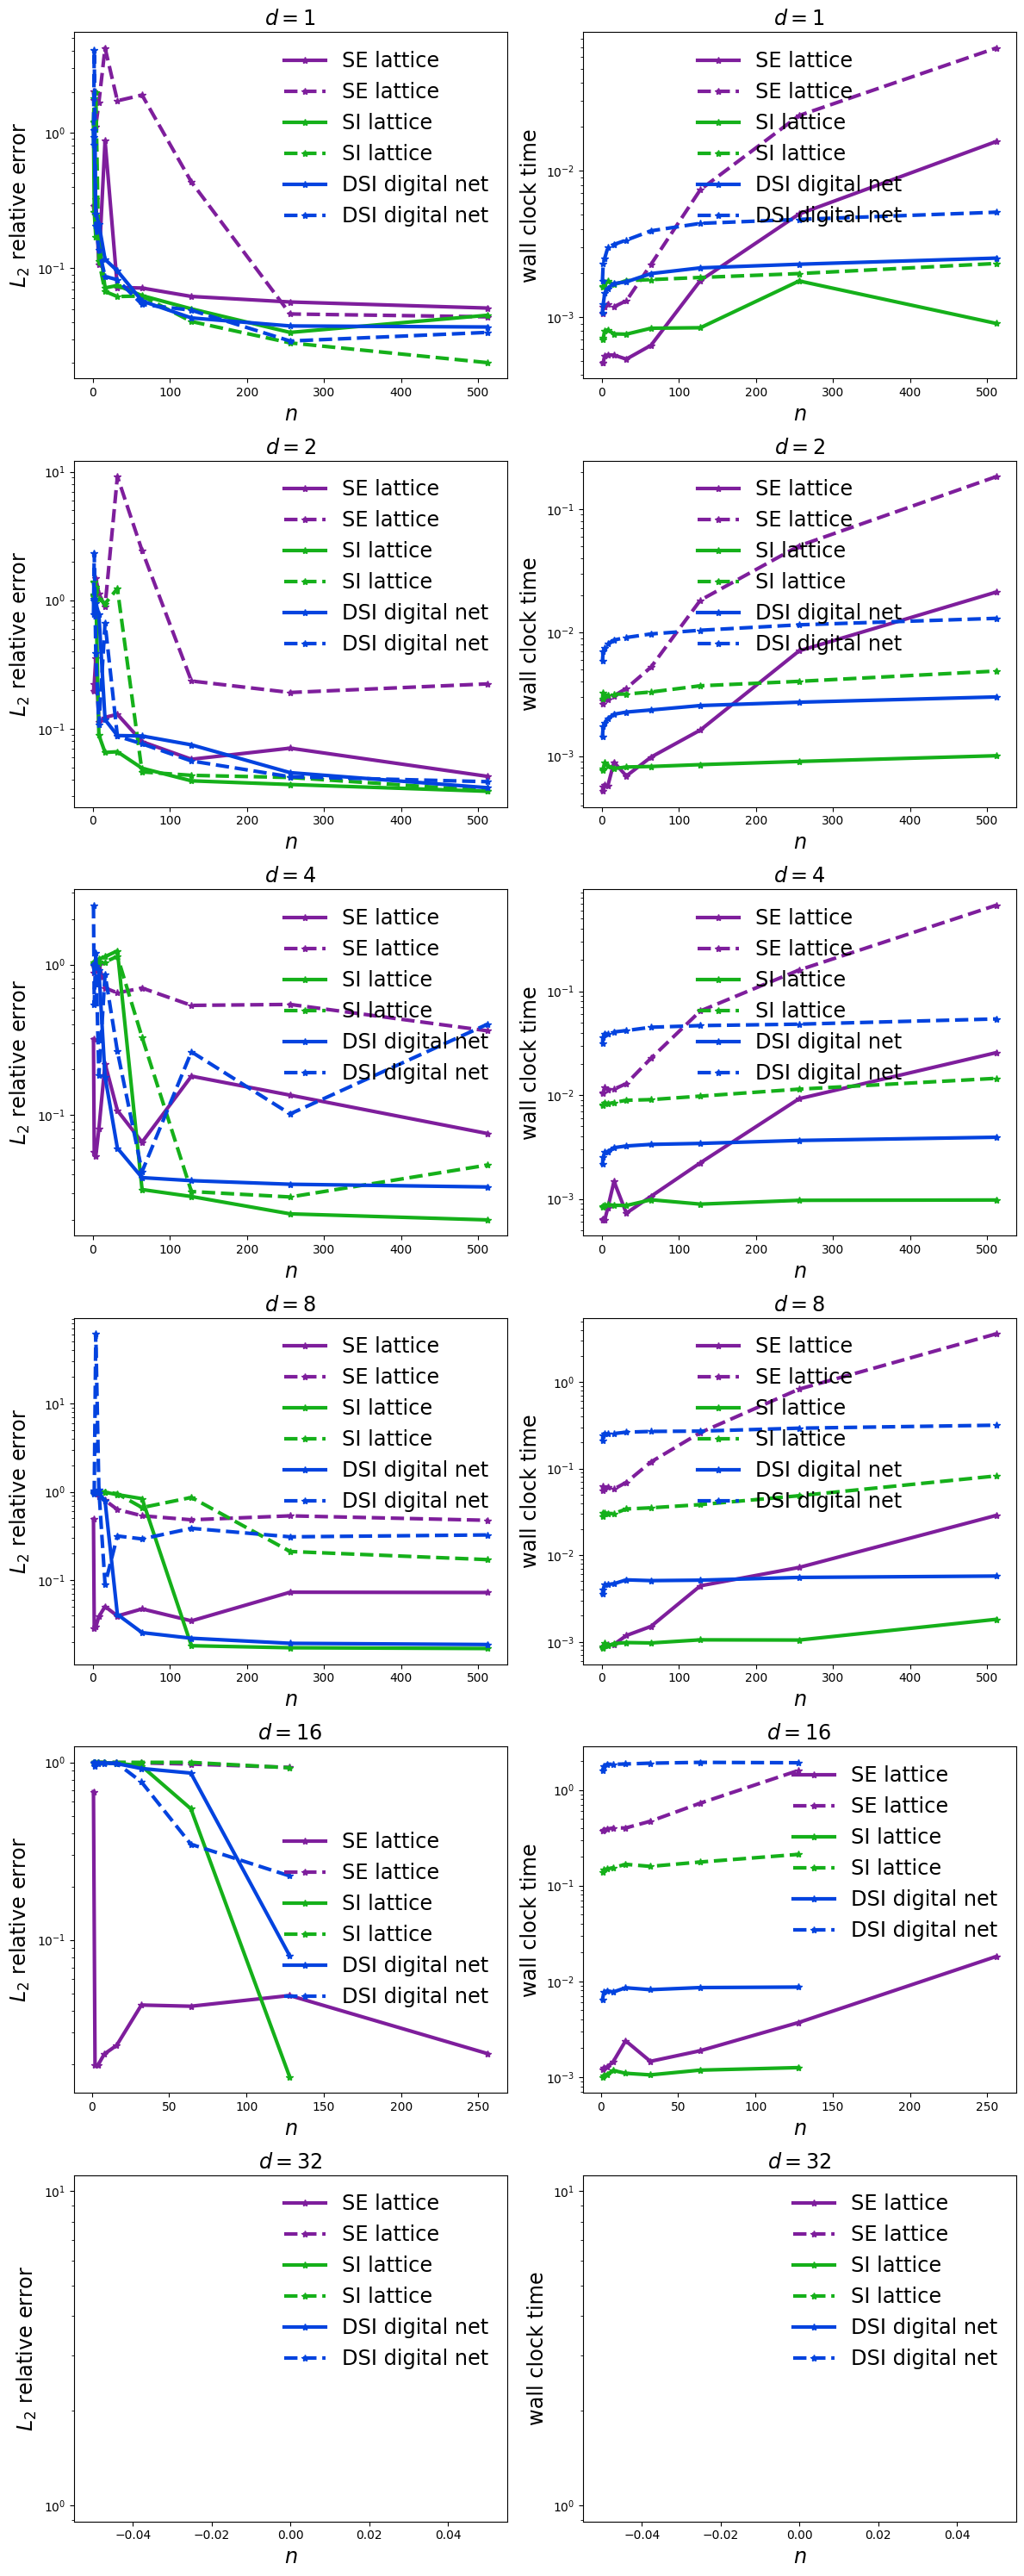

In [ ]:
nrows = len(dvec)
ncols = 2
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(6*ncols,5*nrows))
for j in range(times.size(1)):
    for k in range(times.size(0)):
        ax[j,0].plot(nvec,l2rerrors[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW)
        ax[j,0].plot(nvec,l2rerrors_grad[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW,linestyle='--')
        ax[j,1].plot(nvec,times[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW)
        ax[j,1].plot(nvec,times_grad[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW,linestyle='--')
for j in range(nrows):
    for i in range(ncols):
        #ax[j,i].set_xscale("log",base=10)
        ax[j,i].set_yscale("log",base=10)
        ax[j,i].legend(frameon=False,fontsize="xx-large")
        ax[j,i].set_title(r"$d=%d$"%dvec[j],fontsize="xx-large")
    ax[j,0].set_xlabel(r"$n$",fontsize="xx-large")
    ax[j,0].set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
    ax[j,1].set_xlabel(r"$n$",fontsize="xx-large")
    ax[j,1].set_ylabel("wall clock time",fontsize="xx-large")
fig.tight_layout()
